## 1. Cài đặt và khai báo các thư viện cần thiết

In [ ]:
# Thư viện dành cho excel
!pip install openpyxl

In [ ]:
# Cài đặt xlrd đẻ thao tác trên file excel trong python
!pip install xlrd

Cài đặt thư viện vncorenlp để tách từ cho tiếng Việt

In [ ]:
# Install the vncorenlp python wrapper
!pip install vncorenlp

# Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter)
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2023-07-06 14:37:37--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  --.-KB/s    in 0.1s    

2023-07-06 14:37:37 (186 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2023-07-06 14:37:37--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respon

In [ ]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("/content/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

Tải thư viện transformers để lấy cái tokenizer của vi

In [ ]:
!pip install transformers

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import time
from sklearn import metrics
from pandas import Series, DataFrame
import xlrd
# Dùng đọc các file excel
from xlrd import open_workbook

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import AutoModel, AutoTokenizer, BertTokenizer

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

## 2. Chuẩn bị dữ liệu

### 2.1 Đọc dữ liệu từ file xlsx

Data: https://github.com/TruongNoDame/Comments-Esport-Livestream-Gam-R7

In [ ]:
df = pd.read_excel(
     os.path.join("/content/DataCrawl.xlsx"),
     engine='openpyxl',
)

Xem 5 điểm dữ liệu đầu

In [ ]:
df.head()

,Content,Phi Trường,Duy Trường,Thành Đạt,ChatGPT,Final,Unnamed: 6
0,Trận này gam win nhé,0.0,0.0,0.0,0,0,
1,Trận thua vừa rồi bot GAM đánh tốt nhất team ấy,0.0,0.0,0.0,0,0,NaN
2,để 04 rồi GAM còn gáy làm sao,0.0,0.0,0.0,1,0,NaN
3,ngồi chửi cũng ko giúp SE có cửa đi quốc tế đâ...,1.0,1.0,1.0,1,1,NaN
4,Hài vcl Thực Lực k có kêu Tự Nhục cho Vn? Vậy ...,1.0,1.0,1.0,1,1,NaN


In [ ]:
count_0 = df[df['Final'] == 0].shape[0]
count_1 = df[df['Final'] == 1].shape[0]

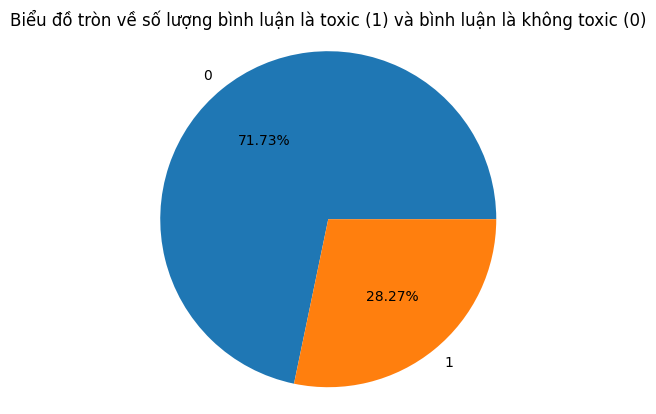

In [ ]:
# Thống kê dataa
import seaborn as sns
import matplotlib.pyplot as plt

plt.pie([count_0, count_1], labels=['0', '1'], autopct='%1.2f%%')
plt.axis('equal')  # Đảm bảo biểu đồ tròn không bị méo
plt.title('Biểu đồ tròn về số lượng bình luận là toxic (1) và bình luận là không toxic (0)')
plt.show()

### 2.2 Tách từ cho dữ liệu tiếng Việt

In [ ]:
# for sample in sentences:
#   text = rdrsegmenter.tokenize(sample)
#   text = ' '.join([' '.join(x) for x in text])
#   vn_core_nlp.append(text)

Truyền dữ đặc trưng vào X và target vào y và tiến hành tách từ các câu trong X sử dụng thư viện vncorenlp.

Sau đó chuyển kiểu dữ liệu của X về DataFrame của pandas

In [ ]:
X = df['Content']
y = df['Final']
X_vi = []
for i in X:
        sample = str(i).strip()# xóa khoảng trắng đầu và cuối
        text = rdrsegmenter.tokenize(sample) # Các từ cấu thành từ ghép sẽ được nối với nhau bởi dấu _
        text = ' '.join([' '.join(x) for x in text]) # Nối các từ lại bởi khoảng trắng
        X_vi.append(text) # Thêm các câu đã tách từ vào mảng Word
X = X_vi
print(X)

['Trận này gam win nhé', 'Trận thua vừa_rồi bot GAM đánh tốt nhất team ấy', 'để 04 rồi GAM còn gáy làm_sao', 'ngồi chửi cũng ko giúp SE có cửa đi quốc_tế đâu fan ngu', 'Hài vcl Thực_Lực k có kêu Tự Nhục cho Vn ? Vậy mấy thằng Gam_Đần thua bạc_nhược Đấm vào mắt Dân Vn xem à', 'vn vô_địch vn vô_địch', 'thua trân này GAM cút về nước đi', 'ae theo kèo gam 2 - 1 R7 nhé', 'gam cút thôi', 'cc gì chậm 12 phút ?', 'go go go', 'GAM anh_cả VCS = ) ) ) nhưng lại rụt cổ cho SGB đi MSI để ăn chửi dùm còn mình cả nhà farm gà , ai dè tụi SGB nó đánh hay vl , còn mình thì vừa khôn_nhà_dại_chợ lại còn hèn nữa .', 'ae ủng_hộ GAM nha không khịa bậy nửa văn_minh lành_mạnh nào : ) ) ) )', 'Mấy th ngu nói se đi may_ra đỡ nhục vậy sao thua gam chi vậy ? Nch ngu vl', 'từ ngày Se bọn nó thành_lập sinh ra 1 lũ súc_vật đi theo.đánh thế_giới mà cứ ở nhà chúng_nó gào khóc trong bất lực.chửi cả đại_diện nước mình tại giải thế_giới trong cay dái', 'trình_độ Việt_Nam ko phải ở cái game rr này ok', 'comebackhome gam', 

In [ ]:
y[0]

0

Sử dụng phobert-base-v2 để vector hóa cho dữ liệu.

In [ ]:
tokenizer_vi = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
test_vi_token = tokenizer_vi.encode("Cái là một sinh viên . Không sao !")
test_vi_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[0, 2510, 8, 16, 418, 1430, 5, 453, 423, 381, 2]

Do các câu có độ dài khác nhau nên ta sẽ cần cắt các câu dài hơn 50 token về 50 token, còn các câu ngắn hơn ta sẽ thêm padding cho chúng bằng các giá trị 1.

Lí do cho padding là 1 mà không phải là 0 bởi vì mặc định phobert-base-2 sẽ cho phần từ bắt đầu có token là 0.

In [ ]:
def encode_with_padding(sentence):
    encoding = tokenizer_vi.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=50,  # Số lượng tối đa token sau khi padding
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'  # Trả về PyTorch tensors
    )
    return tf.convert_to_tensor(encoding['input_ids'].numpy().reshape(-1))

In [ ]:
type(X)

list

Xem định dạng của từng phần tử đã đúng chưa

In [ ]:
print(X[0:2])

['Trận này gam win nhé', 'Trận thua vừa_rồi bot GAM đánh tốt nhất team ấy']


In [ ]:
(encode_with_padding((X[0])))

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([    0,  3132,    23,  5750, 16209,  2083,     2,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1])>

Tiến hành vector hóa cho toàn bộ tập dữ liệu.

In [ ]:
tokens = []
for sample in X:
  tokens.append(encode_with_padding((sample)))

In [ ]:
tokens[0]

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([    0,  3132,    23,  5750, 16209,  2083,     2,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1])>

In [ ]:
X = tf.convert_to_tensor((tokens))

In [ ]:
X = tf.convert_to_tensor(X)

In [ ]:
print(X)

tf.Tensor(
[[    0  3132    23 ...     1     1     1]
 [    0  3132  1156 ...     1     1     1]
 [    0    24  4980 ...     1     1     1]
 ...
 [    0    48  1556 ...     1     1     1]
 [    0 47827   224 ...     1     1     1]
 [    0  7852  5888 ...     1     1     1]], shape=(13779, 50), dtype=int64)


### 2.3 Cân bằng lại dữ liệu

Ta thấy rằng dữ liệu của chúng ta có sự chênh lệch khá lớn giữa nhãn 1 (toxic) và nhãn 0 (không toxic hoặc trung tính). Vì vậy ta cần cân bằng lại tập dữ liệu của chúng ta bị mất cần bằng trước khi đưa qua những thuật toán ML cho việc phân lớp.

`RandomOverSamplier` được sử dụng để thực hiện phương pháp `Random Over-sampling` giúp thực hiện cân bằng dữ liệu.

Phương thức `fit_sampling` sẽ tự động xác định lớp thiểu số trong `y` và thực hiện sao chép ngẫu nhiên các mẫu từ lớp thiểu số này đến khi nào tương đương với lớp đa số.

In [ ]:
print(y)

0        0
1        0
2        0
3        1
4        1
        ..
13774    0
13775    0
13776    0
13777    1
13778    0
Name: Final, Length: 13779, dtype: int64


In [ ]:
# !pip install imbalanced-learn
# from collections import Counter
# from sklearn.datasets import make_classification
# from matplotlib import pyplot
# from numpy import where
# import imblearn
# from imblearn.over_sampling import RandomOverSampler

# # Định nghĩa tập dữ liệu
# counter = Counter(y)
# print(counter)

# # Định nghĩa phương thức undersample từ RandomOverSampler()
# undersample =RandomOverSampler()

# # Biến đổi tập dữ liệu ban đầu bằng undersample để cho tập dữ liệu không bị mất cân bằng
# X, y = undersample.fit_resample(X, y)

# # Đếm lại số lượng của mỗi nhãn
# counter = Counter(y)
# print(counter)

# # Xem thử dữ liệu sau khi cân bằng
# for label, _ in counter.items():
# 	row_ix = where(y == label)[0]
# 	pyplot.scatter(X[row_ix, 1], X[row_ix, 2], label=str(label))
# pyplot.legend()
# pyplot.show()

3 vầ 4 chỉ là các token thứ 3 và 4 của mỗi điểm dữ liệu. Điều này cũng giống như việc ta chuyển từ vector không gian 50 chiều về không gian 2 chiều để quan sát.

In [ ]:
# # Xem thử dữ liệu sau khi cân bằng
# for label, _ in counter.items():
# 	row_ix = where(y == label)[0]
# 	pyplot.scatter(X[row_ix, 3], X[row_ix, 4], label=str(label))
# pyplot.legend()
# pyplot.show()

In [ ]:
# print(counter.items())

### 2.4 Chuyển dữ liệu thành định dạng phù hợp với các mô hình máy học được hỗ trợ bởi thư viện tensorflow.

Tạo một `tf.data.Dataset` bằng `from_tensor_slices()`. `tf.data.Dataset1` sẽ chứa các cặp (x,y) có cùng chỉ mục, trong đó x là một phần tử thuộc X còn y là một phần tử thuộc y.

In [ ]:
data = tf.data.Dataset.from_tensor_slices((X, y))

Sử dụng `cache()` để cải thiện hiệu suất của quá trình huấn luyện. Sau khi đọc dữ liệu từ nguồn ban đầu, dữ liệu sẽ được lưu trữ trong bộ nhớ, giúp tránh việc đọc lại từ nguồn dữ liệu gốc mỗi khi lặp lại quá trình huấn luyện.

In [ ]:
data = data.cache()

Xáo trộn dữ liệu để giúp cho dữ liệu đều hơn. Tránh chỗ có nhiều nhãn 0, chỗ có nhiều nhãn 1.

Đại khái cái prefetch dùng để chuẩn bị một lượng dữ liệu sẵn, trước khi cả mô hình yêu cầu. Ví dụ vô hình đang huấn luyện một bactch dữ liệu trước đó, thay vì chờ huấn luyện xong batch đó mới đọc tiếp batch tiếp theo và thực hiện các tiền xử lí cho bactch data này thì ta chuẩn bị trước lượng data này luôn. Khi model yêu cầu chỉ lấy ra sử dụng.

In [ ]:
data = data.shuffle(15000)
data = data.batch(32)

# Chuẩn bị trước 6 batch
data = data.prefetch(6)

Chia dữ liệu thành các tệp train dev test

In [ ]:
train = data.take(int(len(data) * 0.7)) # Tập train là 70% lượng dữ liệu
dev = data.skip(int(len(data) * 0.7)).take(int(len(data) * 0.2))# Tập development sẽ sử dụng 20% dữ liệu
test = data.skip(int(len(data) * 0.9)).take(int(len(data) * 0.1))# Tập test sẽ sử dụng 10% tập dữ liệu

## 3. Xây dựng mô hình học máy cho bài toán phân loại bình luận toxic trong thể thao điện tử trên livestream.


### 3.1 Thiết kế một mạng học sâu để huấn luyện mô hình.

Reference: [Sequence Classification with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/)

Mạng học sâu của chúng ta có kiến trúc như sau:
* Đầu tiên là khai báo lớp `Sequential`: đây là một lớp trong thư viện Keras của Tensorflow, lớp này giúp ta dễ dàng xây dựng một mạng neural tuần tự (Sequential Neural Network).

* Lớp Embedding: thường được sử dụng để ánh xạ các đối tượng rời rạc như từ, từ vựng hoặc thể hiện số. `top_word` -> số lượng từ tối đa, `embedding_vecor_length` -> chiều dài vector nhúng - tức là chiều của mỗi từ/thể hiện số sẽ được được biểu diễn, `max_review_length` -> độ dài của câu đầu vào - số lượng từ.

* Lớp `Bidirectional` và `LSTM`: Lớp này sử dụng kiến trúc `LSTM` để học được các đặc trưng từ dữ liệu dạng liên tục như chuỗi. Còn lớp `Bidirectional` là một lớp đặc biệt, nó sẽ tạo ra hai bản `LSTM`, một bản sẽ học các đặc trưng trong câu theo chiều từ đầu đến cuối, một bản sẽ học các đặc trưng từ cuối lên đầu, sau đó sẽ tổng hợp lại để tạo thành một đầu ra có thông tin ngữ nghĩa của cả hai chiều trong một câu. Hàm kích hoạt được sử dụng là `tanh`.

* Tiếp theo là các lớp ẩn (Dense), ở đây ta sử dụng 7 lớp ẩn để học được các mối quan hệ tuyến tính và phi tuyến tính. Hàm kích hoạt được sử dụng là `ReLU`.

* Lớp Dense cuối cùng sẽ là đầu ra của mô hình, lớp này sẽ chỉ có một đầu ra là xác xuất dự đoán của model nằm trong khoảng 0 -> 1. Hàm kích hoạt được sử dụng là `sigmoid`.



In [ ]:
top_words = 200000
embedding_vecor_length = 64
max_review_length = 50

In [ ]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(top_words + 1, embedding_vecor_length))

# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))

# Các lớp kết nối đầy đủ giúp rút trích đặc trưng
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Lớp đầu ra
model.add(Dense(1, activation='sigmoid'))

### Kiến thức cần biết:
* Chúng ta sẽ xây dựng một mô deep neural networks, mạng này nhận vào một input là X và trả ra output Y. Và có thể được mô tả như sau:
### $f(X) \rightarrow Y$.

* Hàm tanh có công thức như sau:
### $tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $
Hàm tanh này nhận đầu vào là một số thực và đầu ra sẽ là một giá trị trobg khoảng từ (-1; 1). Hàm này bị bão hòa ở 2 đầu (gradient thay đổi rất ít ở hai đầu).
![Tanh function](https://www.researchgate.net/publication/340644173/figure/fig2/AS:880423089491969@1586920630956/3a-Graph-of-the-tanh-function-3b-Graph-of-gradient-of-tanh-function.ppm)

* Hàm sigmoid:
### $\sigma(x) = \frac{1}{1 + e^{-x}}$
Tương tự như hàm tanh hàm này cũng nhận đầu vào là một số thực, chỉ khác đầu ra của hàm này nằm trong khoảng (0; 1).![Sigmoid function](https://ambrapaliaidata.blob.core.windows.net/ai-storage/articles/Untitled_design_13.png)

* Hàm ReLU:
#$f(x) = max(0, x)$
Hàm ReLU chỉ đơn giản là cho tất cả các giá trị < 0 về 0.
![ReLU function](https://michielstraat.com/talk/mastertalk/featured.png)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Như bên trên ta thấy hàm compile nhận hàm loss là `binary_crossentropy`, dùng `adam` để tối ưu và metrics là `accuracy`.

* Về binary cross entropy:
Tham khảo: https://ndquy.github.io/posts/loss-function-p2/

Cross-entropy là hàm loss được sử dụng mặc định cho bài toán phân lớp nhị phân.

Nó được thiết kế để sử dụng với bài toán phân loại nhị phân trong đó các giá trị mục tiêu nhận một trong 2 giá trị {0, 1}.

Về mặt toán học, nếu như MSE tính khoảng cách giữa 2 đại lượng số thì cross-entropy hiểu nôm na là phương pháp tính khoảng cách giữa 2 phân bố xác suất.

### $H(p, q) = E_p[- \log(q)]$

Với p và q là rời rạc (như y - nhãn thật sự và y^ - nhãn dự đoán ) trong bài toán của chúng ta), công thức này được viết dưới dạng:

### $H(p,q) = \sum_{i=1}^{C} p_i\log(q_i)$

Trong đó C là số lượng các class cần phân lớp, trong bài toán binary classification thì C = 2.

Hàm mất mát: Binary Cross Entropy tính toán độ chênh lệch giữa 2 phân phối xác suất của dự đoán và của nhãn. Đầu ra của mô hình là phân phối xác suất (p, 1 - p) biểu diễn xác suất xảy ra của một trong hai nhãn. Phân phối xác suất của nhãn có dạng (y, 1 - y) với y nhận giá trị 0 hoặc 1.


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          12800064  
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 128)               8320      
                                                                 
 dense_18 (Dense)            (None, 256)               33024     
                                                                 
 dense_19 (Dense)            (None, 512)               131584    
                                                      

## 4. Huấn luyện mô hình

### 4.1 Huấn luyện mô hình.

In [ ]:
model_ = model.fit(train, epochs=10, validation_data=dev)

Epoch 1/10
301/301 [==============================] - 27s 67ms/step - loss: 0.4059 - accuracy: 0.8226 - val_loss: 0.2572 - val_accuracy: 0.9110
Epoch 2/10
301/301 [==============================] - 7s 23ms/step - loss: 0.2449 - accuracy: 0.9073 - val_loss: 0.2057 - val_accuracy: 0.9360
Epoch 3/10
301/301 [==============================] - 5s 18ms/step - loss: 0.2091 - accuracy: 0.9236 - val_loss: 0.1771 - val_accuracy: 0.9364
Epoch 4/10
301/301 [==============================] - 5s 18ms/step - loss: 0.1790 - accuracy: 0.9340 - val_loss: 0.1750 - val_accuracy: 0.9353
Epoch 5/10
301/301 [==============================] - 5s 17ms/step - loss: 0.1614 - accuracy: 0.9385 - val_loss: 0.1225 - val_accuracy: 0.9531
Epoch 6/10
301/301 [==============================] - 7s 23ms/step - loss: 0.1407 - accuracy: 0.9468 - val_loss: 0.1455 - val_accuracy: 0.9557
Epoch 7/10
301/301 [==============================] - 5s 17ms/step - loss: 0.1285 - accuracy: 0.9510 - val_loss: 0.1055 - val_accuracy: 0.965

Lưu lại model để sử dụng vào lần sau

In [ ]:
model.save("/content/drive/MyDrive/Machine_Learning/weight/my_model_easport.h5")

### 4.2 Quan sát độ lỗi và accuracy của model trên tập train và trên tập dev

<Figure size 1200x800 with 0 Axes>

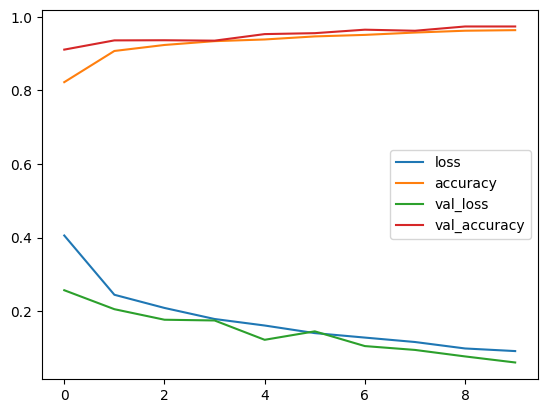

In [ ]:
plt.figure(figsize=(12,8))
pd.DataFrame(model_.history).plot()
plt.show()

## 5. Dự đoán thử vài mẫu và đánh giá mô hình đã huấn luyện

### 5.1 Dự đoán một vài bình luận

In [ ]:
sentence1 = encode_with_padding('Trận này thắng rồi')
sentence2 = encode_with_padding('Lệ vi đánh đần ác, già rồi thì cút về vườn cho thế trẻ nó lên')

In [ ]:
sentences = []
sentences.append(sentence1)
sentences.append(sentence2)
sentences = tf.convert_to_tensor(sentences)

In [ ]:
print(sentences)

tf.Tensor(
[[    0  3132    23   616   182     2     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1]
 [    0  9125  5237   480 56781  5796  1395     4  1687   182    54 18265
     28  1333    13   570   177   231    72     2     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1]], shape=(2, 50), dtype=int64)


In [ ]:
pred = model.predict(sentences)

1/1 [==============================] - 1s 1s/step


In [ ]:
pred

array([[1.9386856e-05],
       [9.9999201e-01]], dtype=float32)

In [ ]:
pred = (pred > 0.5).astype(int)

In [ ]:
if(pred[0][0] == 0):
  print("Trận này thắng rồi: không toxic" )
else:
  print("Trận này thắng rồi: toxic" )

if(pred[1][0] == 0):
  print("Lệ vi đánh đần ác, già rồi thì cút về vườn cho thế trẻ nó lên: không toxic" )
else:
  print("Lệ vi đánh đần ác, già rồi thì cút về vườn cho thế trẻ nó lên: toxic" )

Trận này thắng rồi: không toxic
Lệ vi đánh đần ác, già rồi thì cút về vườn cho thế trẻ nó lên: toxic


In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 30ms/step


array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

### 5.2 Đánh giá mô hình đã huấn luyện

Ta sẽ sử dụng 3 độ đo để đánh giá mô hình

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
p = Precision()
r = Recall()
a = CategoricalAccuracy()

In [ ]:
y_label = []
y_pred = []

for batch in test.as_numpy_iterator():
  X_true, y_true = batch

  pred = model.predict(X_true)

  y_true = y_true.flatten()
  pred = pred.flatten()

  p.update_state(y_true, pred)
  r.update_state(y_true, pred)
  a.update_state(y_true, pred)

  for i in y_true:
    y_label.append(i)
  for i in pred:
    if i > 0.5:
      y_pred.append(1)
    else:
      y_pred.append(0)

1/1 [==============================] - 0s 25ms/step


In [ ]:
print("Nhãn ban đầu của tập test:")
print(y_label)
print("Nhãn khi được dự đoán bằng mô hình:")
print(y_pred)

Nhãn ban đầu của tập test:
[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 

Đếm số lượng nhãn là toxic và không toxic trước và sau khi dự đoán

In [ ]:
toxic = 0
khong_toxic = 0
du_doan_toxic = 0
du_doan_khong_toxic = 0
for i in range(0,len(y_label)):
  if y_label[i] == 1:
    toxic += 1
  if y_label[i] == 0:
    khong_toxic += 1
  if y_pred[i] == 1:
    du_doan_toxic += 1
  if y_pred[i] == 0:
    du_doan_khong_toxic += 1

In [ ]:
# Tổng số dự đoán đúng
count = 0
for i in range(0,len(y_label)):
  if y_label[i] == y_pred[i]:
    count+=1
print("Tổng số bình luận mà mô hình dự đoán chính xác trên tập test:", count)

Tổng số bình luận mà mô hình dự đoán chính xác trên tập test: 1347


Thống kê các nhãn là toxic và không toxic trước và sau khi dự đoán

In [ ]:
print("Số nhãn toxic trên tập test: ", toxic)
print("Số nhãn không toxic trên tập test:",khong_toxic)
print("Số nhãn được dự đoán là toxic trên tập test: ",du_doan_toxic)
print("Số nhãn được dự đoán không phải toxic trên tập test: ",du_doan_khong_toxic)

Số nhãn toxic trên tập test:  375
Số nhãn không toxic trên tập test: 1001
Số nhãn được dự đoán là toxic trên tập test:  370
Số nhãn được dự đoán không phải toxic trên tập test:  1006


Confusion matrix:
[[989  12]
 [ 17 358]]


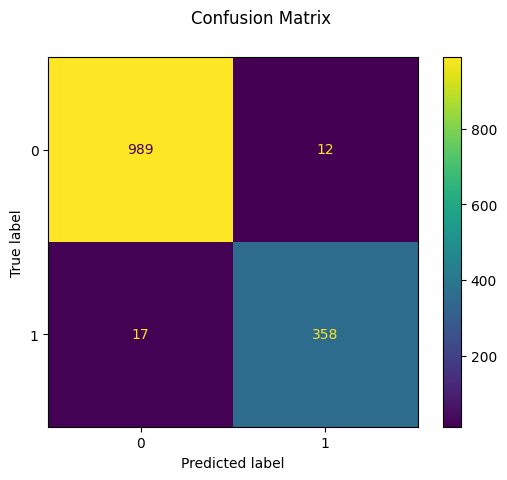

In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_label, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

In [ ]:
print(f'Precision: {p.result().numpy()}')
print(f'Recall:{r.result().numpy()}')
print(f'F1 Score: {2*p.result().numpy()*r.result().numpy()/(p.result().numpy()+r.result().numpy())}')
print(f'Accuracy:{count/len(y_label)}')

Precision: 0.9675675630569458
Recall:0.9546666741371155
F1 Score: 0.9610737972627666
Accuracy:0.9789244186046512
